<a href="https://colab.research.google.com/github/dmora4/network_measurements_course/blob/lecture3/NML_Lecture03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lecture 3: Flows and Such

Here, we are "connecting" our personal Google Drive to this notebook. This is a quick way to access potentially many files we may need to import. 

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


The `traffic_captures/` folder in our Drive contains csv files that correspond to network traffic while using specified apps to perform some task (ie, APP: DropBox, TASK: Download; APP: Google Maps, Task: Browse, etc...)

First, let's focus on *one* CSV file. 

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from dateutil import tz


import pytz

df = pd.read_csv('/content/drive/MyDrive/traffic_captures/dropbox_download_2019-03-16_11-46-54_5bd0c615.csv')
df.head(4)

,Unnamed: 0,frame.number,frame.time,frame.len,frame.cap_len,sll.pkttype,sll.hatype,sll.halen,sll.src.eth,sll.unused,...,tcp.option_len,tcp.options.timestamp.tsval,tcp.options.timestamp.tsecr,udp.srcport,udp.dstport,udp.length,udp.checksum,gquic.puflags.rsv,gquic.packet_number,location
0,0,1,"Mar 16, 2019 11:46:56.648665000 CDT",79,44,4,1,6,fc:c2:de:bc:a6:23,00:00,...,NaN,NaN,NaN,60759.0,53.0,43.0,0x00004e97,NaN,NaN,Prather
1,1,2,"Mar 16, 2019 11:46:56.664544000 CDT",271,44,0,1,6,00:6c:bc:1c:5f:b9,00:00,...,NaN,NaN,NaN,53.0,60759.0,235.0,0x0000d790,NaN,NaN,Prather
2,2,3,"Mar 16, 2019 11:46:56.670898000 CDT",76,76,4,1,6,fc:c2:de:bc:a6:23,00:00,...,"4,2,10,3",3798737.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,Prather
3,3,4,"Mar 16, 2019 11:46:56.713290000 CDT",76,76,0,1,6,00:6c:bc:1c:5f:b9,00:00,...,"4,2,10,3",846969304.0,3798737.0,NaN,NaN,NaN,NaN,NaN,NaN,Prather


We are dealing with alotttt of columns!! 

Our objective is to group packets belonging to the same *flow*. A flow is defined as a unique `{SRC-IP}{SRC-Port}{DST-IP}{DST-Port}` combination. Previously we uses lists/ hashes/ sets/ etc to organize the rows into the different flows or "conversations". Instead, we can do this with the `groupby()` function in `pandas`. For now, let's assume we already have all the flows seperated. 

**Exercise:** Let's make a function `extract_features()` that takes in the following parameters:
*   `flow`: the ID of the flow; `{SRC-IP}{SRC-Port}{DST-IP}{DST-Port}`
*   `df_flow`: the messages excahnged in that flow; ie, the "contents of the conversation"


Notice, in the column for IP_Protocol, the ID for UDP is 17 and the ID for TCP is 6.

*What is interarrival time?* This is the duration of time elapsed between two messages in the flow. Note the fencepost problem: if we calculate the time between msg_x and msg_x-1, we have to *skip* the first message, msg_0 because msg_-1 does not exist.

In [ ]:




# Define a function to parse a string into a datetime object with timezone information
def parse_datetime_with_timezone(dt_str):
  # Define timezone information for CDT
  CDT = tz.gettz('America/Chicago')
  dt_str = dt_str.replace(' CDT', '')
  dt = pd.to_datetime(dt_str, format='%b %d, %Y %H:%M:%S.%f', errors='coerce')
  return dt.replace(tzinfo=CDT)



def extract_features(flow, df_flow):
  flow_features = {}
  flow_features['num_packets'] = len(df_flow)
  flow_features['sport'] = flow[2]
  flow_features['dport'] = flow[3]
  pkt_sizes = df_flow['ip.len'].astype(float)
  flow_features['total_bytes'] = pkt_sizes.sum()

  flow_features['min_pkt_size'] = pkt_sizes.min()
  flow_features['max_pkt_size'] = pkt_sizes.max()
  flow_features['avg_pkt_size'] = pkt_sizes.mean()
  flow_features['std_pkt_size'] = pkt_sizes.std()

  # Apply the custom function to the "frame.time" column of the DataFrame
  df_flow['frame.time'] = df_flow['frame.time'].apply(parse_datetime_with_timezone)

  # Calculate the inter-arrival times in seconds
  iat = df_flow['frame.time'].diff(1).dt.total_seconds().iloc[1:]

  flow_features['min_iat'] = iat.min()
  flow_features['max_iat'] = iat.max()
  flow_features['avg_iat'] = iat.mean()
  flow_features['std_iat'] = iat.std()
  flow_features['dur'] = iat.sum()

  return flow_features

Let's dissect this :

```
iat = pd.to_datetime(df_flow['frame.time']).diff(1).dt.total_seconds().iloc[1:]
```

`df_flow['frame.time']` take only the frame.time column 

`.to_datetime()` pass our frame.time column and convert it to datatime format so correctly interpret the seconds of iat (interarrival time). 

`.diff(1)` We find the discrete difference between adjacent elements

`.dt.total_seconds()` returns total duration of each element expressed in seconds

`.iloc[1:0]` The first "diff" element calculated is not meaningful. Thus, we only take the resulting vector from the second element (index 1) and on.  




Now, let's only consider TCP traffic. Recall, the TCP protocol is identified as 6.

This way of extracting rows from a column where val == X is called *conditional indexing.*


> `for flow, df_flow in df_flows_tcp:`

This way of iterating extracts the flow ID (flow) and the contents of the flow (df_flow). Don't believe me? See the output of the `print()`


In [ ]:

df_tcp = df[df["ip.proto"] == 6] #conditional indexing
df_tcp.head(3)
# Using groupby to get all unique flow IDs
df_flows_tcp = df_tcp.groupby(["ip.src", "ip.dst", "tcp.srcport", "tcp.dstport"])

# This was of iterating extracts the flow ID (flow) and the contents of the flow (df_flow)
for flow, df_flow in df_flows_tcp:
  print(flow)
  display(extract_features(flow, df_flow))

('10.145.43.25', '162.125.18.133', 39735.0, 443.0)


{'num_packets': 13,
 'sport': 39735.0,
 'dport': 443.0,
 'total_bytes': 2285.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 930.0,
 'avg_pkt_size': 175.76923076923077,
 'std_pkt_size': 251.22737173264446,
 'min_iat': 0.000119,
 'max_iat': 15.003027000000001,
 'avg_iat': 1.4761664166666668,
 'std_iat': 4.315487475542868,
 'dur': 17.713997000000003}

('10.145.43.25', '162.125.8.5', 49876.0, 443.0)


{'num_packets': 28,
 'sport': 49876.0,
 'dport': 443.0,
 'total_bytes': 3009.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 693.0,
 'avg_pkt_size': 107.46428571428571,
 'std_pkt_size': 167.67063881816975,
 'min_iat': 0.000161,
 'max_iat': 17.195918000000002,
 'avg_iat': 0.6691442962962962,
 'std_iat': 3.3046296870596197,
 'dur': 18.066896}

('10.145.43.25', '162.125.8.7', 37761.0, 443.0)


{'num_packets': 16,
 'sport': 37761.0,
 'dport': 443.0,
 'total_bytes': 2077.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 673.0,
 'avg_pkt_size': 129.8125,
 'std_pkt_size': 157.86121277882037,
 'min_iat': 9.1e-05,
 'max_iat': 17.525113,
 'avg_iat': 1.2137168000000003,
 'std_iat': 4.512714751312597,
 'dur': 18.205752000000004}

('10.145.43.25', '162.125.8.7', 37762.0, 443.0)


{'num_packets': 24,
 'sport': 37762.0,
 'dport': 443.0,
 'total_bytes': 5716.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 912.0,
 'avg_pkt_size': 238.16666666666666,
 'std_pkt_size': 314.0067385965753,
 'min_iat': 9.800000000000001e-05,
 'max_iat': 6.014194000000001,
 'avg_iat': 0.8099906956521739,
 'std_iat': 1.8574789784494186,
 'dur': 18.629786}

('10.145.43.25', '162.125.8.7', 37763.0, 443.0)


{'num_packets': 15,
 'sport': 37763.0,
 'dport': 443.0,
 'total_bytes': 3122.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 826.0,
 'avg_pkt_size': 208.13333333333333,
 'std_pkt_size': 286.26033772141915,
 'min_iat': 0.00011200000000000001,
 'max_iat': 17.434059,
 'avg_iat': 1.3368107857142861,
 'std_iat': 4.636800729313548,
 'dur': 18.715351000000005}

('10.145.43.25', '162.125.8.7', 37764.0, 443.0)


{'num_packets': 19,
 'sport': 37764.0,
 'dport': 443.0,
 'total_bytes': 4143.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 833.0,
 'avg_pkt_size': 218.05263157894737,
 'std_pkt_size': 261.16394886571635,
 'min_iat': 9.900000000000001e-05,
 'max_iat': 14.054760000000002,
 'avg_iat': 1.0201807777777778,
 'std_iat': 3.3328068890004374,
 'dur': 18.363254}

('10.145.43.25', '162.125.8.7', 37765.0, 443.0)


{'num_packets': 17,
 'sport': 37765.0,
 'dport': 443.0,
 'total_bytes': 3491.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 833.0,
 'avg_pkt_size': 205.35294117647058,
 'std_pkt_size': 257.9537122180233,
 'min_iat': 0.000124,
 'max_iat': 17.438889,
 'avg_iat': 1.148163375,
 'std_iat': 4.345013260114264,
 'dur': 18.370614}

('10.145.43.25', '162.125.8.7', 37766.0, 443.0)


{'num_packets': 12,
 'sport': 37766.0,
 'dport': 443.0,
 'total_bytes': 2157.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 826.0,
 'avg_pkt_size': 179.75,
 'std_pkt_size': 250.39609530792316,
 'min_iat': 0.00014000000000000001,
 'max_iat': 17.459131000000003,
 'avg_iat': 1.6233860000000002,
 'std_iat': 5.25254519057628,
 'dur': 17.857246000000004}

('10.145.43.25', '162.125.8.7', 37767.0, 443.0)


{'num_packets': 14,
 'sport': 37767.0,
 'dport': 443.0,
 'total_bytes': 1604.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 610.0,
 'avg_pkt_size': 114.57142857142857,
 'std_pkt_size': 152.11873615735144,
 'min_iat': 0.000388,
 'max_iat': 20.001051,
 'avg_iat': 1.5557856923076925,
 'std_iat': 5.542212552459161,
 'dur': 20.225214}

('10.145.43.25', '162.125.8.7', 37768.0, 443.0)


{'num_packets': 14,
 'sport': 37768.0,
 'dport': 443.0,
 'total_bytes': 1555.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 558.0,
 'avg_pkt_size': 111.07142857142857,
 'std_pkt_size': 139.38847998184195,
 'min_iat': 0.000105,
 'max_iat': 20.000778,
 'avg_iat': 1.5553393076923077,
 'std_iat': 5.542257768182346,
 'dur': 20.219411}

('10.145.43.25', '162.125.8.7', 37769.0, 443.0)


{'num_packets': 14,
 'sport': 37769.0,
 'dport': 443.0,
 'total_bytes': 1820.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 826.0,
 'avg_pkt_size': 130.0,
 'std_pkt_size': 207.21040959892397,
 'min_iat': 9.2e-05,
 'max_iat': 20.000652000000002,
 'avg_iat': 1.5569447692307696,
 'std_iat': 5.541801268158157,
 'dur': 20.240282000000004}

('10.145.43.25', '162.125.8.7', 37771.0, 443.0)


{'num_packets': 13,
 'sport': 37771.0,
 'dport': 443.0,
 'total_bytes': 1504.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 559.0,
 'avg_pkt_size': 115.6923076923077,
 'std_pkt_size': 144.25289402953908,
 'min_iat': 0.00013900000000000002,
 'max_iat': 20.000528000000003,
 'avg_iat': 1.68584825,
 'std_iat': 5.767825496845476,
 'dur': 20.230179}

('10.145.43.25', '162.125.8.8', 37739.0, 443.0)


{'num_packets': 176,
 'sport': 37739.0,
 'dport': 443.0,
 'total_bytes': 10010.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 647.0,
 'avg_pkt_size': 56.875,
 'std_pkt_size': 46.891927419790036,
 'min_iat': 0.00010700000000000001,
 'max_iat': 0.386166,
 'avg_iat': 0.003643062857142858,
 'std_iat': 0.029368717484424385,
 'dur': 0.6375360000000001}

('10.145.43.25', '23.23.212.91', 35960.0, 443.0)


{'num_packets': 19,
 'sport': 35960.0,
 'dport': 443.0,
 'total_bytes': 2559.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 1290.0,
 'avg_pkt_size': 134.68421052631578,
 'std_pkt_size': 283.93349233610223,
 'min_iat': 0.000109,
 'max_iat': 0.084078,
 'avg_iat': 0.0161185,
 'std_iat': 0.024992959383300213,
 'dur': 0.29013300000000003}

('162.125.18.133', '10.145.43.25', 443.0, 39735.0)


{'num_packets': 12,
 'sport': 443.0,
 'dport': 39735.0,
 'total_bytes': 4451.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 1290.0,
 'avg_pkt_size': 370.9166666666667,
 'std_pkt_size': 502.039197733211,
 'min_iat': 0.000174,
 'max_iat': 14.976931,
 'avg_iat': 1.6029971818181818,
 'std_iat': 4.493299163707372,
 'dur': 17.632969}

('162.125.8.5', '10.145.43.25', 443.0, 49876.0)


{'num_packets': 28,
 'sport': 443.0,
 'dport': 49876.0,
 'total_bytes': 25247.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 1290.0,
 'avg_pkt_size': 901.6785714285714,
 'std_pkt_size': 546.3606903578019,
 'min_iat': 9e-05,
 'max_iat': 17.205450000000003,
 'avg_iat': 0.6685214814814815,
 'std_iat': 3.306381266759342,
 'dur': 18.05008}

('162.125.8.7', '10.145.43.25', 443.0, 37761.0)


{'num_packets': 19,
 'sport': 443.0,
 'dport': 37761.0,
 'total_bytes': 7965.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 1290.0,
 'avg_pkt_size': 419.2105263157895,
 'std_pkt_size': 451.7845576706973,
 'min_iat': 0.000105,
 'max_iat': 17.55795,
 'avg_iat': 1.010840888888889,
 'std_iat': 4.129880853887048,
 'dur': 18.195136}

('162.125.8.7', '10.145.43.25', 443.0, 37762.0)


{'num_packets': 26,
 'sport': 443.0,
 'dport': 37762.0,
 'total_bytes': 10285.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 1290.0,
 'avg_pkt_size': 395.5769230769231,
 'std_pkt_size': 456.0680802754714,
 'min_iat': 0.000106,
 'max_iat': 6.038082,
 'avg_iat': 0.74466956,
 'std_iat': 1.7990992279067526,
 'dur': 18.616739}

('162.125.8.7', '10.145.43.25', 443.0, 37763.0)


{'num_packets': 16,
 'sport': 443.0,
 'dport': 37763.0,
 'total_bytes': 7637.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 1290.0,
 'avg_pkt_size': 477.3125,
 'std_pkt_size': 517.7759771368309,
 'min_iat': 0.000114,
 'max_iat': 17.458978000000002,
 'avg_iat': 1.2465586000000002,
 'std_iat': 4.4886827234137705,
 'dur': 18.698379000000003}

('162.125.8.7', '10.145.43.25', 443.0, 37764.0)


{'num_packets': 23,
 'sport': 443.0,
 'dport': 37764.0,
 'total_bytes': 8487.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 1290.0,
 'avg_pkt_size': 369.0,
 'std_pkt_size': 435.0874520244073,
 'min_iat': 0.00011,
 'max_iat': 14.089008000000002,
 'avg_iat': 0.8342685454545454,
 'std_iat': 3.0335991393503705,
 'dur': 18.353908}

('162.125.8.7', '10.145.43.25', 443.0, 37765.0)


{'num_packets': 19,
 'sport': 443.0,
 'dport': 37765.0,
 'total_bytes': 8256.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 1290.0,
 'avg_pkt_size': 434.5263157894737,
 'std_pkt_size': 483.5357470895511,
 'min_iat': 0.000115,
 'max_iat': 17.450483000000002,
 'avg_iat': 1.019751722222222,
 'std_iat': 4.101237525973375,
 'dur': 18.355531}

('162.125.8.7', '10.145.43.25', 443.0, 37766.0)


{'num_packets': 13,
 'sport': 443.0,
 'dport': 37766.0,
 'total_bytes': 6873.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 1290.0,
 'avg_pkt_size': 528.6923076923077,
 'std_pkt_size': 547.8020300277866,
 'min_iat': 0.00012800000000000002,
 'max_iat': 17.494974000000003,
 'avg_iat': 1.487279166666667,
 'std_iat': 5.041342717760362,
 'dur': 17.847350000000002}

('162.125.8.7', '10.145.43.25', 443.0, 37767.0)


{'num_packets': 12,
 'sport': 443.0,
 'dport': 37767.0,
 'total_bytes': 5627.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 1290.0,
 'avg_pkt_size': 468.9166666666667,
 'std_pkt_size': 542.4477282455774,
 'min_iat': 0.000105,
 'max_iat': 20.028815,
 'avg_iat': 1.8378660000000002,
 'std_iat': 6.033311818470466,
 'dur': 20.216526}

('162.125.8.7', '10.145.43.25', 443.0, 37768.0)


{'num_packets': 13,
 'sport': 443.0,
 'dport': 37768.0,
 'total_bytes': 5678.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 1290.0,
 'avg_pkt_size': 436.7692307692308,
 'std_pkt_size': 532.0459181070362,
 'min_iat': 0.000127,
 'max_iat': 20.020792,
 'avg_iat': 1.684283416666667,
 'std_iat': 5.774556743326688,
 'dur': 20.211401000000002}

('162.125.8.7', '10.145.43.25', 443.0, 37769.0)


{'num_packets': 13,
 'sport': 443.0,
 'dport': 37769.0,
 'total_bytes': 6109.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 1290.0,
 'avg_pkt_size': 469.9230769230769,
 'std_pkt_size': 555.6979787526166,
 'min_iat': 9.2e-05,
 'max_iat': 20.011424,
 'avg_iat': 1.6859494166666666,
 'std_iat': 5.771119271164516,
 'dur': 20.231393}

('162.125.8.7', '10.145.43.25', 443.0, 37771.0)


{'num_packets': 13,
 'sport': 443.0,
 'dport': 37771.0,
 'total_bytes': 6104.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 1290.0,
 'avg_pkt_size': 469.53846153846155,
 'std_pkt_size': 555.2818526635243,
 'min_iat': 0.00014700000000000002,
 'max_iat': 20.015238,
 'avg_iat': 1.6851190000000003,
 'std_iat': 5.772586010535927,
 'dur': 20.221428000000003}

('162.125.8.8', '10.145.43.25', 443.0, 37739.0)


{'num_packets': 396,
 'sport': 443.0,
 'dport': 37739.0,
 'total_bytes': 503743.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 1290.0,
 'avg_pkt_size': 1272.078282828283,
 'std_pkt_size': 144.28176172918305,
 'min_iat': 4.5e-05,
 'max_iat': 0.328421,
 'avg_iat': 0.001566974683544304,
 'std_iat': 0.01699558422104359,
 'dur': 0.618955}

('23.23.212.91', '10.145.43.25', 443.0, 35960.0)


{'num_packets': 17,
 'sport': 443.0,
 'dport': 35960.0,
 'total_bytes': 6940.0,
 'min_pkt_size': 52.0,
 'max_pkt_size': 576.0,
 'avg_pkt_size': 408.2352941176471,
 'std_pkt_size': 227.90253657313818,
 'min_iat': 0.000106,
 'max_iat': 0.06848800000000001,
 'avg_iat': 0.012996625000000001,
 'std_iat': 0.02276186938390606,
 'dur': 0.20794600000000002}

*Think Bigger* Okay so now our objective is to get a DataFrame where each *row* is a different flow and the data in the columns correpsond with all the characteristics of that flow *plus* the APP  that generated that flow. This resulting DataFrame will be our training set. 

In [ ]:
# lists all the files from a path
from os import listdir
from os.path import isfile, join

path = '/content/drive/MyDrive/traffic_captures/'

dumpfiles = [f for f in listdir(path) if isfile(join(path, f))]


apps = np.unique([f.split('_')[0] for f in dumpfiles])




print(apps)

dataset = pd.DataFrame()

for f in dumpfiles:
  if(f == '.DS_Store'):
    break
  else:
    print('Processing file: ', f)
    df = pd.read_csv(join(path,f))
    df_tcp = df[df["ip.proto"] == 6] 
    df_flows_tcp = df_tcp.groupby(["ip.src", "ip.dst", "tcp.srcport", "tcp.dstport"])
    this_app = f.split('_')[0]

    for flow, df_flow in df_flows_tcp:
      flow_features = extract_features(flow, df_flow);
      flow_features['app'] = this_app
      #only add downlink direction 
      if(flow[0].split('.')[0] == '10'):
        flow_features['direction'] = 'uplink'
      else:
        flow_features['direction'] = 'downlink'

      # For this example, we are only interested in downlinks
      if(flow_features['direction'] == 'downlink'):
        # here we use ';' to supress warning outputs
        # dataset = dataset.append(flow_features, ignore_index=True);


        df_row = pd.DataFrame(flow_features, index=[0])
        dataset = pd.concat([dataset, df_row], ignore_index=True)

display(dataset)

['.DS' 'dropbox' 'facebook' 'gmail' 'google-drive' 'google-maps' 'netflix']
Processing file:  facebook_scroll-newsfeed_2019-03-16_09-29-11_4fd1c357.csv
Processing file:  facebook_scroll-newsfeed_2019-03-16_09-33-23_4fd1c357.csv
Processing file:  facebook_scroll-newsfeed_2019-03-16_09-32-03_4fd1c357.csv
Processing file:  facebook_search-page_2019-03-16_09-30-58_5bd0c615.csv
Processing file:  google-maps_directions_2019-03-16_09-33-10_5bd0c615.csv
Processing file:  facebook_search-page_2019-03-16_09-34-20_5bd0c615.csv
Processing file:  google-drive_download_2019-03-16_09-28-20_4fd1c357.csv


<ipython-input-12-d6d992735049>:23: DtypeWarning: Columns (39) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(join(path,f))


Processing file:  google-drive_upload_2019-03-16_09-28-26_5bd0c615.csv


<ipython-input-12-d6d992735049>:23: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(join(path,f))


Processing file:  netflix_watch-video_2019-03-16_09-31-10_4fd1c357.csv
Processing file:  google-maps_directions_2019-03-16_10-56-48_5bd0c615.csv
Processing file:  facebook_search-page_2019-03-16_10-51-57_4fd1c357.csv
Processing file:  facebook_scroll-newsfeed_2019-03-16_10-51-42_5bd0c615.csv
Processing file:  facebook_scroll-newsfeed_2019-03-16_10-51-41_4fd1c357.csv
Processing file:  dropbox_upload_2019-03-16_10-51-06_4fd1c357.csv
Processing file:  facebook_search-page_2019-03-16_10-51-58_5bd0c615.csv
Processing file:  google-drive_download_2019-03-16_10-53-27_4fd1c357.csv


<ipython-input-12-d6d992735049>:23: DtypeWarning: Columns (33,39) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(join(path,f))


Processing file:  google-drive_download_2019-03-16_10-53-29_5bd0c615.csv


<ipython-input-12-d6d992735049>:23: DtypeWarning: Columns (39) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(join(path,f))


Processing file:  google-drive_upload_2019-03-16_10-54-30_5bd0c615.csv


<ipython-input-12-d6d992735049>:23: DtypeWarning: Columns (33,39) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(join(path,f))


Processing file:  google-drive_upload_2019-03-16_10-54-40_4fd1c357.csv


<ipython-input-12-d6d992735049>:23: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(join(path,f))


Processing file:  google-maps_browse_2019-03-16_10-56-24_4fd1c357.csv
Processing file:  google-maps_directions_2019-03-16_10-56-56_4fd1c357.csv
Processing file:  dropbox_upload_2019-03-16_11-33-08_4fd1c357.csv
Processing file:  dropbox_upload_2019-03-16_12-01-12_5bd0c615.csv
Processing file:  dropbox_upload_2019-03-16_11-51-11_4fd1c357.csv
Processing file:  dropbox_download_2019-03-16_12-09-23_5bd0c615.csv
Processing file:  facebook_search-page_2019-03-16_12-02-42_5bd0c615.csv
Processing file:  dropbox_download_2019-03-16_11-46-54_5bd0c615.csv
Processing file:  facebook_search-page_2019-03-16_12-14-52_4fd1c357.csv
Processing file:  facebook_scroll-newsfeed_2019-03-16_11-56-26_5bd0c615.csv
Processing file:  facebook_search-page_2019-03-16_11-37-07_4fd1c357.csv
Processing file:  facebook_scroll-newsfeed_2019-03-16_11-48-37_4fd1c357.csv
Processing file:  facebook_scroll-newsfeed_2019-03-16_11-40-54_5bd0c615.csv
Processing file:  google-drive_download_2019-03-16_11-32-53_5bd0c615.csv


<ipython-input-12-d6d992735049>:23: DtypeWarning: Columns (39) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(join(path,f))


Processing file:  facebook_search-page_2019-03-16_12-20-36_5bd0c615.csv
Processing file:  google-drive_upload_2019-03-16_11-50-03_4fd1c357.csv
Processing file:  google-maps_browse_2019-03-16_11-26-28_4fd1c357.csv
Processing file:  facebook_search-page_2019-03-16_12-23-09_5bd0c615.csv
Processing file:  gmail_open-email_2019-03-16_12-06-13_5bd0c615.csv
Processing file:  google-maps_directions_2019-03-16_11-34-28_5bd0c615.csv
Processing file:  gmail_open-email_2019-03-16_11-53-48_4fd1c357.csv
Processing file:  gmail_open-email_2019-03-16_11-42-34_5bd0c615.csv
Processing file:  google-maps_directions_2019-03-16_11-44-28_5bd0c615.csv
Processing file:  gmail_open-email_2019-03-16_12-16-03_5bd0c615.csv
Processing file:  google-drive_upload_2019-03-16_11-51-33_5bd0c615.csv
Processing file:  google-drive_upload_2019-03-16_12-04-58_4fd1c357.csv
Processing file:  google-drive_upload_2019-03-16_11-59-40_4fd1c357.csv
Processing file:  google-drive_upload_2019-03-16_12-00-16_5bd0c615.csv
Processing 

<ipython-input-12-d6d992735049>:23: DtypeWarning: Columns (11,12,13,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(join(path,f))


Processing file:  netflix_watch-video_2019-03-16_11-36-05_4fd1c357.csv


<ipython-input-12-d6d992735049>:23: DtypeWarning: Columns (11,12,13,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(join(path,f))


Processing file:  netflix_watch-video_2019-03-16_11-39-19_5bd0c615.csv


<ipython-input-12-d6d992735049>:23: DtypeWarning: Columns (11,12,13,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(join(path,f))


Processing file:  netflix_watch-video_2019-03-16_11-40-04_4fd1c357.csv
Processing file:  netflix_watch-video_2019-03-16_11-44-41_4fd1c357.csv
Processing file:  netflix_watch-video_2019-03-16_12-14-35_5bd0c615.csv


<ipython-input-12-d6d992735049>:23: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(join(path,f))


Processing file:  netflix_watch-video_2019-03-16_12-11-31_5bd0c615.csv
Processing file:  netflix_watch-video_2019-03-16_12-17-10_4fd1c357.csv
Processing file:  netflix_watch-video_2019-03-16_12-19-06_5bd0c615.csv
Processing file:  dropbox_download_2019-03-16_15-27-33_5bd0c615.csv
Processing file:  facebook_search-page_2019-03-16_14-38-58_5bd0c615.csv
Processing file:  dropbox_upload_2019-03-16_14-46-09_4fd1c357.csv
Processing file:  dropbox_upload_2019-03-16_14-40-35_4fd1c357.csv
Processing file:  dropbox_download_2019-03-16_16-03-08_5bd0c615.csv
Processing file:  gmail_open-email_2019-03-16_14-41-04_5bd0c615.csv
Processing file:  dropbox_upload_2019-03-16_15-29-32_4fd1c357.csv
Processing file:  gmail_open-email_2019-03-16_14-58-01_4fd1c357.csv
Processing file:  dropbox_upload_2019-03-16_15-16-28_4fd1c357.csv
Processing file:  facebook_scroll-newsfeed_2019-03-16_15-46-29_5bd0c615.csv
Processing file:  google-drive_download_2019-03-16_14-42-06_4fd1c357.csv
Processing file:  gmail_open-e

,num_packets,sport,dport,total_bytes,min_pkt_size,max_pkt_size,avg_pkt_size,std_pkt_size,min_iat,max_iat,avg_iat,std_iat,dur,app,direction
0,5,443.0,53065.0,715.0,52.0,268.0,143.000000,94.127573,0.000088,0.020352,0.008185,0.009458,0.032739,facebook,downlink
1,2260,443.0,53066.0,2759118.0,52.0,1290.0,1220.848673,266.588815,0.000026,1.206596,0.002946,0.037058,6.655564,facebook,downlink
2,442,443.0,48732.0,556765.0,52.0,1290.0,1259.649321,181.045118,0.000029,0.173078,0.001161,0.010428,0.512030,facebook,downlink
3,5,443.0,48733.0,715.0,52.0,268.0,143.000000,94.127573,0.000080,0.058284,0.023538,0.028326,0.094153,facebook,downlink
4,1,443.0,48862.0,85.0,85.0,85.0,85.000000,NaN,NaN,NaN,NaN,NaN,0.000000,facebook,downlink
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
898,12,443.0,35453.0,1479.0,52.0,386.0,123.250000,108.572661,0.000097,0.041232,0.010613,0.013517,0.116743,facebook,downlink
899,152,443.0,42801.0,177820.0,52.0,1290.0,1169.868421,350.139191,0.000021,0.858058,0.009526,0.072137,1.438392,facebook,downlink
900,5,443.0,60227.0,715.0,52.0,268.0,143.000000,94.127573,0.000079,0.018896,0.007620,0.009135,0.030481,facebook,downlink
901,460,443.0,60228.0,572405.0,52.0,1290.0,1244.358696,211.748051,0.000020,0.023074,0.000377,0.001825,0.172903,facebook,downlink


In [ ]:
apps = np.delete(apps, np.where(apps == '.DS'))

Now we save our training data backto a csv!

In [ ]:

dataset.to_csv('/content/drive/MyDrive/Colab Notebooks/traffic_classification_dataset.csv', index=False, line_terminator='\n')


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay


X = dataset.drop(['direction', 'sport', 'dport'], axis=1).dropna()
APP = X['app']
X = X.drop(['app'], axis=1)


#selects indexes for training and test set (70/30)
idx = np.random.permutation(len(X))
num_train_obs = np.floor(0.7*len(X))

train_idx =idx[1:int(num_train_obs)] 
test_idx = idx[int(num_train_obs):]

#data normalization
X_norm = pd.DataFrame()

for key in X:
  temp = X[key]
  temp_norm = (temp - temp.mean())/temp.std();
  X_norm[key] = temp_norm


X_norm_train = X_norm.iloc[train_idx]
X_norm_test = X_norm.iloc[test_idx]


APP_train = APP.iloc[train_idx]
APP_test = APP.iloc[test_idx]


In [ ]:
display(X_norm_test)

,num_packets,total_bytes,min_pkt_size,max_pkt_size,avg_pkt_size,std_pkt_size,min_iat,max_iat,avg_iat,std_iat,dur
880,-0.213737,-0.197132,-0.053062,0.506015,-0.256112,0.867116,-0.053072,1.821517,2.031768,2.224360,1.270146
338,2.319768,2.453027,-0.053062,0.506015,1.952091,-1.292743,-0.068994,3.117898,-0.574243,-0.417858,2.753912
587,0.938884,1.009948,-0.053062,0.506015,1.950354,-1.202007,-0.070763,1.869686,-0.569239,-0.418585,1.736669
103,-0.211643,-0.195748,-0.053062,0.506015,0.008501,0.984955,-0.024413,3.921234,2.815096,3.758379,2.983074
77,-0.215412,-0.197472,-0.053062,0.506015,-0.012923,1.049583,-0.060148,-0.686925,-0.566506,-0.599234,-0.757871
...,...,...,...,...,...,...,...,...,...,...,...
53,-0.210805,-0.196986,-0.053062,0.506015,-0.622743,0.408135,-0.071471,4.057739,2.570291,3.643012,3.122313
550,-0.142955,-0.118492,21.951916,0.506015,1.996263,-1.642964,-0.070409,1.836233,-0.408178,0.125266,1.289495
379,-0.215412,-0.197398,-0.053062,0.506015,0.051499,1.043941,0.039982,-0.691580,-0.575056,-0.605294,-0.762310
302,-0.215412,-0.197550,-0.053062,0.506015,-0.080341,1.065915,-0.067579,-0.687990,-0.560152,-0.600297,-0.754572


0.7510204081632653


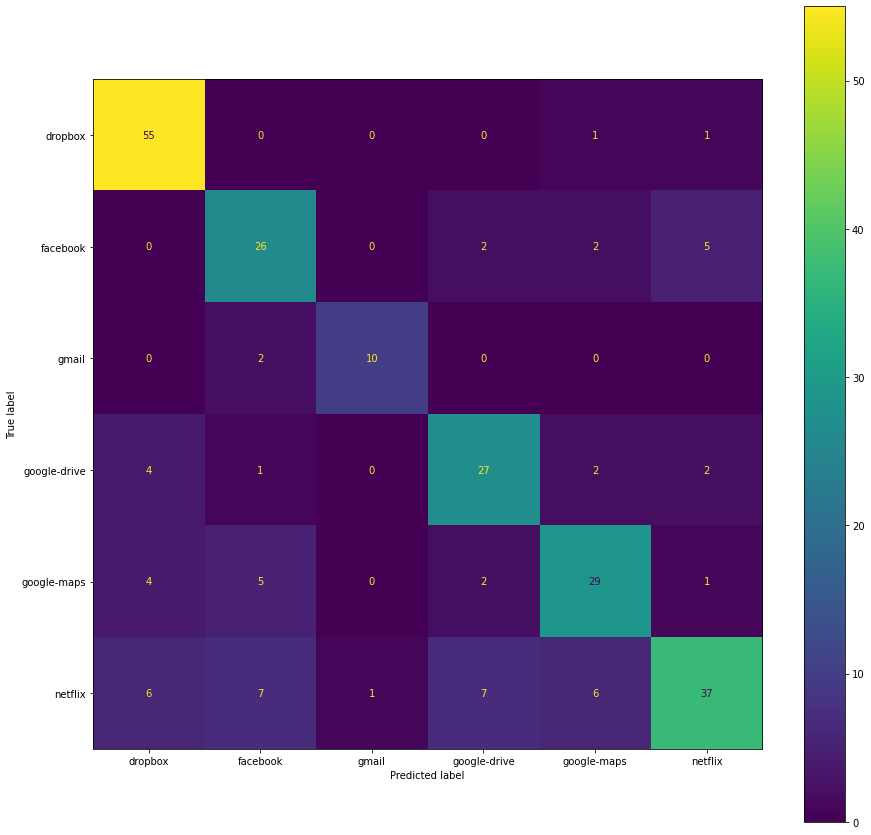

In [ ]:

#knn classifier

#pick the 10 closest entries, pick majority

i = 0
accuracy = 0
K = 10

APP_test_predicted = []
for index, row in X_norm_test.iterrows():
  distances = []
  for ii, rr in X_norm_train.iterrows():
    distances.append(np.linalg.norm(np.array(row-rr.to_numpy())))

  min_idx = np.argmin(distances)

  predicted_app = APP_train.iloc[min_idx]
  APP_test_predicted.append(predicted_app) #

  if(APP_test.iloc[i] == predicted_app):
    accuracy = accuracy + 1
  i = i + 1 



print(accuracy/len(APP_test))

fig, ax = plt.subplots(figsize=(15, 15));
ConfusionMatrixDisplay.from_predictions(APP_test_predicted, APP_test, ax=ax);


#fig, ax = plt.subplots.from_predictions(APP_test_predicted, APP_test, ax)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample


from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import  classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB


#constructing features
le = LabelEncoder();
scaler = StandardScaler();


#using only traffic features
X = dataset.drop(['direction','sport','dport'],axis=1).dropna();

#port-based classification, usable port information is source port
#X = dataset[['sport','app']]


Y = le.fit_transform(X['app']);
X = X.drop('app',axis=1);

X_norm = scaler.fit_transform(X);


#now let's use a stratified k-fold cross validation approach with 5 splits
tot_cm = np.zeros([len(apps),len(apps)])
skf = StratifiedKFold(n_splits=5,shuffle=True)
print('KNN')
for train, test in skf.split(X_norm, Y):
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_norm[train], Y[train])
    knn_predict = knn.predict(X_norm[test])
    knn_report = classification_report(Y[test],knn_predict,target_names=le.inverse_transform(np.arange(len(apps))),digits=3,output_dict=True)
    fold_accuracy = knn_report['accuracy']
    print(fold_accuracy)
    cm = confusion_matrix(Y[test],knn.predict(X_norm[test]))
    tot_cm = tot_cm + cm;

print('Random Forest')
#other approach: a random forest classifier
for train, test in skf.split(X_norm, Y):
    clf = RandomForestClassifier()
    clf.fit(X_norm[train], Y[train])
    y_pred = clf.predict(X_norm[test])
    clf_report = classification_report(Y[test],y_pred,target_names=le.inverse_transform(np.arange(len(apps))),digits=3,output_dict=True)
    fold_accuracy = clf_report['accuracy']
    print(fold_accuracy)
    cm = confusion_matrix(Y[test],knn.predict(X_norm[test]))
    tot_cm = tot_cm + cm;


KNN
0.7177914110429447
0.7423312883435583
0.7730061349693251
0.7668711656441718
0.6932515337423313
Random Forest
0.852760736196319
0.7668711656441718
0.7975460122699386
0.8220858895705522
0.7730061349693251
